In [33]:
import control as ctl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from scipy.optimize import fsolve
from tbcontrol.symbolic import routh

In [34]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=6):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

# INFORMAÇÕES DO SISTEMA
- Declarando a função de transferência e obtendo os parâmetros

In [35]:
s  = ctl.TransferFunction.s
G = 1/(s**2 + 2*s)
G_bkp = G
G

TransferFunction(array([1]), array([1, 2, 0]))

polos:  (-2+0j) 0j
zeros: 


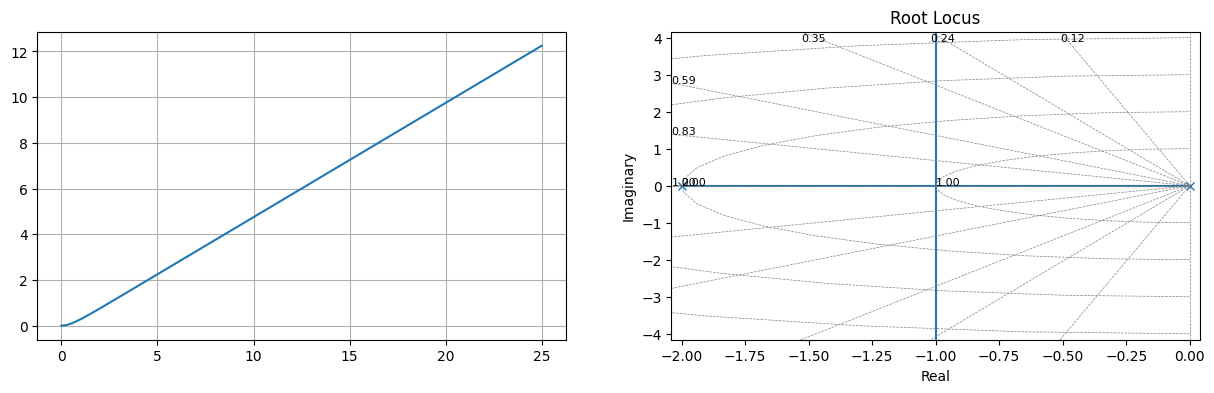

In [36]:
poles = ctl.poles(G)
zeros = ctl.zeros(G)
print('polos: ', *[np.round(pole, 3) for pole in poles])
print('zeros: ', *[np.round(zero, 3) for zero in zeros])

time, response = ctl.step_response(G)
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.grid()

plt.subplot(1, 2, 2)
ctl.root_locus(G)

plt.show()

# REQUISITOS DO SISTEMA
- Os requisitos do sistema serão encontrados a partir do overshoot e tempo de establização máximos permitidos

In [37]:
Ts = 1
UP = 0.1

- $\zeta = -\frac{ln(UP\%)}{\sqrt{\pi² + ln²(UP\%)}}$

In [38]:
zeta = -np.log(UP)/np.sqrt(np.pi**2 + np.log(UP)**2)
zeta

0.5911550337988976

- $\omega_n = \frac{4}{\zeta\,t_s}$ 

In [39]:
Wn = 4/(zeta*Ts)
Wn

6.766414512780318

- $s_d = -\zeta\omega_n \pm \omega_n\sqrt{1-\zeta²}j$

In [40]:
s_d = -zeta*Wn + Wn*np.sqrt(1-zeta**2)*sp.I
s_d = roundSympyFunction(s_d, 3)

s_d

-4.0 + 5.458*I

# CONTROLADOR LEAD
- Encontrando as constantes do controlador: $C(s) = K\frac{s-a}{s-b}$

In [41]:
G = sympyFunction(G)
G

1/(s**2 + 2*s)

In [42]:
angle = sp.arg(G.subs(s, s_d))
angle = float(angle)
angle

2.1579055047482933

In [43]:
phi = angle - np.pi
phi

-0.9836871488414998

In [44]:
a = sp.re(s_d) + sp.im(s_d)*np.tan(phi/2)
a = float(a)
a

-6.924174389507778

In [45]:
b = sp.re(s_d) + sp.im(s_d)*np.tan(3/2*phi)
b = float(b)
b

-61.119108730639944

In [46]:
G_ma = G * (s - a)/(s - b)

K = 1/sp.Abs(G_ma.subs(s, s_d))
K = roundSympyFunction(sp.N(K))
K = float(K)
K

364.5049560070038

In [47]:
C = K*(s - a)/(s - b)
C

(364.504956007004*s + 2523.89588123235)/(s + 61.1191087306399)

- Declarando as funções de transferência em malha aberta e malha fechada com o novo controlador

In [48]:
s = ctl.TransferFunction.s
G = G_bkp

C  = K*(s - a)/(s - b)
C1 = C 

G_ma = G*C
T = ctl.feedback(G_ma, 1)
T

TransferFunction(array([ 364.50495601, 2523.89588123]), array([1.00000000e+00, 6.31191087e+01, 4.86743173e+02, 2.52389588e+03]))

- Conferindo a resposta

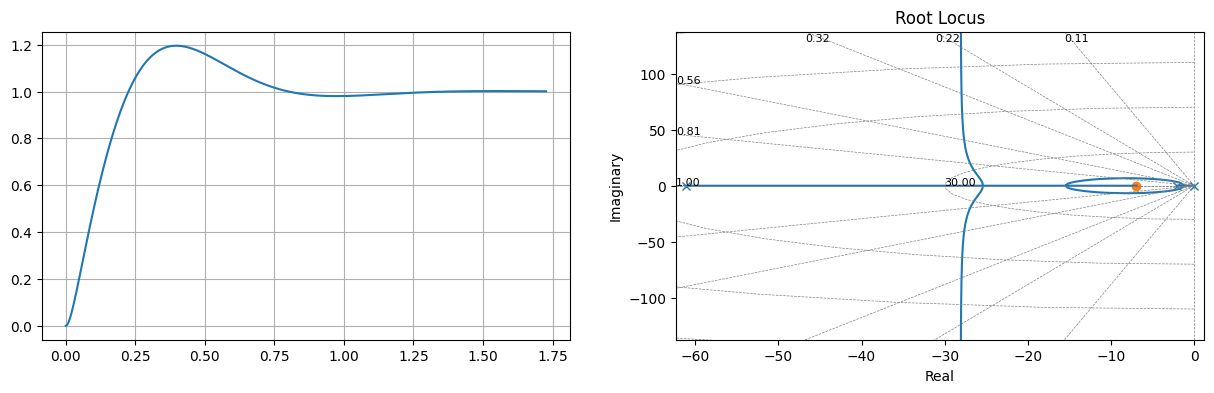

In [49]:
time, response = ctl.step_response(T)
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.grid()

plt.subplot(1, 2, 2)
ctl.root_locus(G_ma)
plt.show()

# CONTROLADOR LAG
- Mais recomendado para entrada em rampa
- Encontrando as constantes do controlador: $C(s) = \frac{s-a}{s-b}$
- Como estamos projetando um controlador a partir de outro, a nova função de transferência será aquela com o controlador LEAD em malha aberta

In [50]:
G = G * C1

G = sympyFunction(G)
G

(364.504956007004*s + 2523.89588123235)/(1.0*s**3 + 63.1191087306399*s**2 + 122.23821746128*s)

In [51]:
Kp = G.subs(s, 1e-5)
Kp

2064727.82924970

In [52]:
e_ss = 0.1
K_desired = 1/e_ss - 1
K_desired

9.0

In [53]:
K_lag = abs(K_desired/Kp)
K_lag = float(K_lag)
K_lag

4.358928025526007e-06

In [54]:
a = float(sp.re(s_d) * 1/9)
a

-0.4444444444444444

In [55]:
b = float(a/K_lag)
b

-101961.86811109637

In [56]:
C  = (s - a)/(s - b)
C

(s + 0.444444444444444)/(s + 101961.868111096)

- Conferindo a resposta

In [57]:
s = ctl.TransferFunction.s
G = G_bkp

C  = (s - a)/(s - b)
C2 = C 

G_ma = G*C
T = ctl.feedback(G_ma, 1)
T

TransferFunction(array([1.        , 0.44444444]), array([1.00000000e+00, 1.01963868e+05, 2.03924736e+05, 4.44444444e-01]))

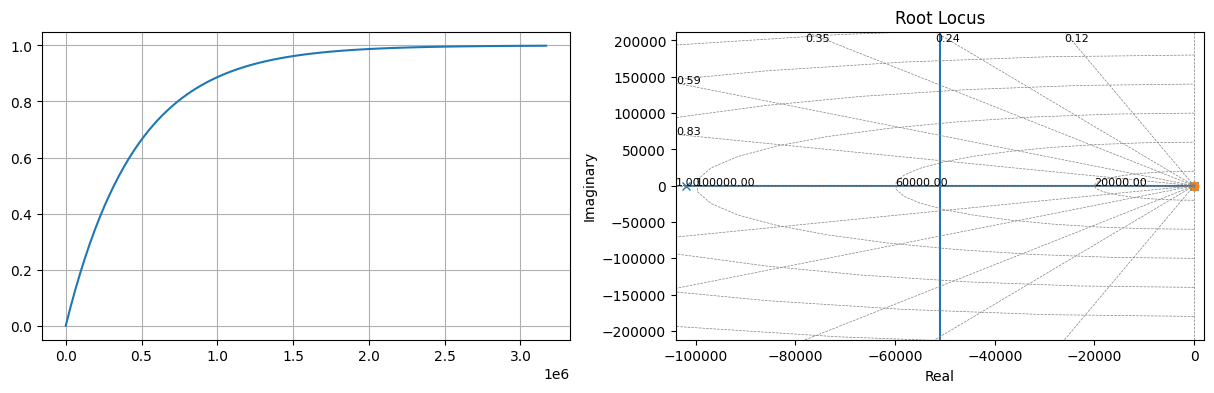

In [58]:
time, response = ctl.step_response(T)
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.grid()

plt.subplot(1, 2, 2)
ctl.root_locus(G_ma)
plt.show()

# RESPOSTA CONTROLADA

In [59]:
C = C1 * C2
C

TransferFunction(array([ 364.50495601, 2685.8980839 , 1121.73150277]), array([1.00000000e+00, 1.02022987e+05, 6.23181850e+06]))

In [60]:
G_ma = G * C
G_ma

TransferFunction(array([ 364.50495601, 2685.8980839 , 1121.73150277]), array([1.00000000e+00, 1.02024987e+05, 6.43586448e+06, 1.24636370e+07,
       0.00000000e+00]))

In [61]:
G_feedback = ctl.feedback(G_ma, 1)
G_feedback

TransferFunction(array([ 364.50495601, 2685.8980839 , 1121.73150277]), array([1.00000000e+00, 1.02024987e+05, 6.43622898e+06, 1.24663229e+07,
       1.12173150e+03]))

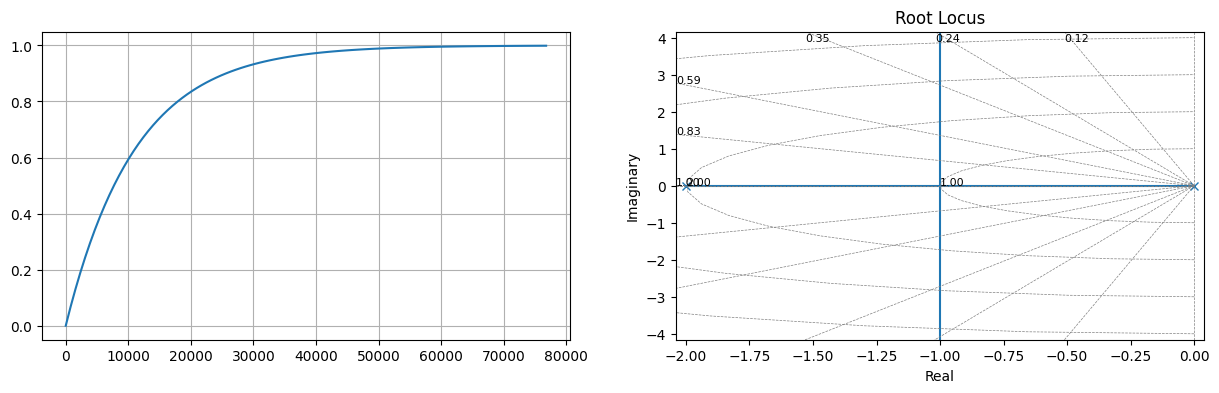

In [62]:
time, response = ctl.step_response(G_feedback)
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.grid()

plt.subplot(1, 2, 2)
ctl.root_locus(G)

plt.show()

In [63]:
def getOvershoot(time, response):
    peak_value = np.max(response)
    steady_state_value = response[-1]
    overshoot = (peak_value - steady_state_value) / steady_state_value
    return 'inf' if overshoot < 0 or overshoot > 999 else overshoot

def getZeta(overshoot):
    return -np.log(overshoot) / np.sqrt((np.pi**2 + np.log(overshoot)**2))

def getPeakTime(time, response):
    return time[response == max(response)][0] #time[np.argmax(response)]

def getError(response, setpoint=1):
    return abs(setpoint - abs(response[-1]))

def getSettlingTime(time, response, tolerance=0.02):
    steady_state_value = np.mean(response[-50:])
    settling_time = None
    
    if abs(steady_state_value) < 1e-6:
        lower_bound = -tolerance
        upper_bound = tolerance
    else:
        upper_bound = steady_state_value * (1 + tolerance)
        lower_bound = steady_state_value * (1 - tolerance)
    
    for i in range(len(time)):
        if lower_bound <= response[i] <= upper_bound:
            if settling_time is None:
                settling_time = time[i]
        else:
            settling_time = None
    
    return settling_time

def getAllInfo(time, response, show=True, setpoint=1):
    info = {
        'overshoot': getOvershoot(time, response),
        'peakValue': max(response),
        'peakTime': getPeakTime(time, response),
        'settlingTime': getSettlingTime(time, response),
        'finalValue': response[-1],
        'error': getError(response, setpoint)
    }

    if not show:
        return info

    print('overshoot: ', info['overshoot'])
    print('valor de pico: ', info['peakValue'])
    print('tempo de pico: ', info['peakTime'])
    print('tempo de assentamento: ', info['settlingTime'])
    print('valor final: ', info['finalValue'])
    print('erro: ', info['error'])


getAllInfo(time, response, setpoint=1)

overshoot:  0.0
valor de pico:  0.9990001630064541
tempo de pico:  76765.52447752572
tempo de assentamento:  39545.8762459981
valor final:  0.9990001630064541
erro:  0.0009998369935458884


# APLICANDO VÁRIOS STEPS

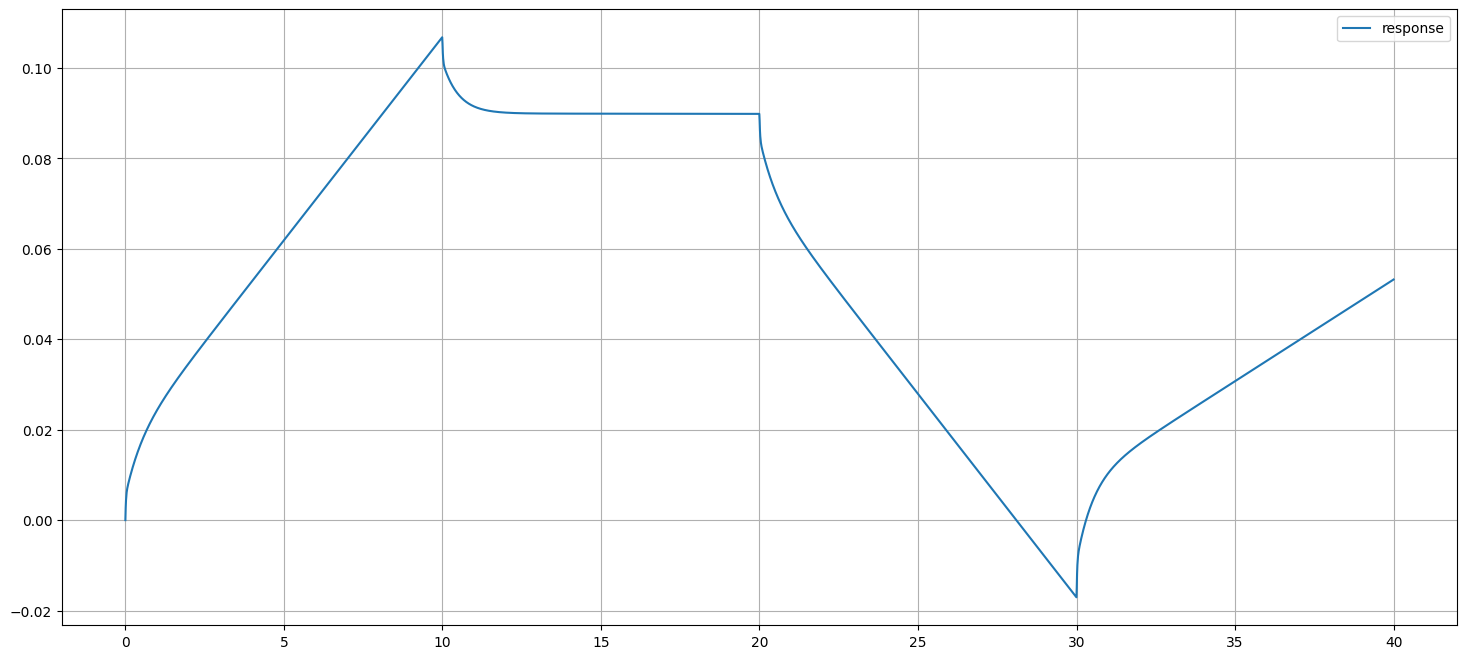

In [64]:
uData = [100 for i in range(1000)] + [0 for i in range(1000)] + [-100 for i in range(1000)] + [50 for i in range(1000)]
tData = np.linspace(0, 40, len(uData))

plt.figure(figsize=(18, 8))
time, response = ctl.forced_response(G_feedback, T=tData, U=uData)
plt.plot(time, response, label='response')
plt.legend()
plt.grid()